In [42]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

/kaggle/input/an-online-shop-business/Sales Transaction v.4a.csv


In [43]:
os.listdir('/kaggle/input/an-online-shop-business')

['Sales Transaction v.4a.csv']

In [44]:
data = pd.read_csv('/kaggle/input/an-online-shop-business/Sales Transaction v.4a.csv')

data.head(5)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [45]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


# Creating necessary columns

In [46]:
# Making sure Date is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

# Year column
data['Year'] = pd.DatetimeIndex(data['Date']).year

# Month column
data['Month'] = pd.DatetimeIndex(data['Date']).month

# Day column
data['Day'] = pd.DatetimeIndex(data['Date']).day

data.head(5)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalAmount,Year,Month,Day
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,2019,12,9
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,2019,12,9
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,2019,12,9
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,2019,12,9
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,2019,12,9


# Dropping null columns

In [47]:
# Validating null values
data.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
TotalAmount       0
Year              0
Month             0
Day               0
dtype: int64

In [48]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price             0
Quantity       8585
TotalAmount    8585
dtype: int64

In [49]:
# Deleting all rows with null values
data = data.dropna(subset = ['CustomerNo'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

In [50]:
# Validating null values again
data.isnull().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       0
Country          0
TotalAmount      0
Year             0
Month            0
Day              0
dtype: int64

# Price, Quantity and Total Amount distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

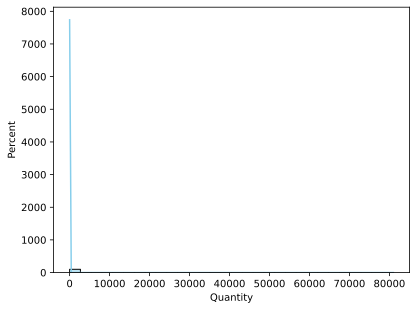

In [51]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

In [52]:
# Distribution for Price
print(data['Price'].describe())

# Sesgo de los datos! buscar funcion

count    527764.000000
mean         12.629640
std           7.933224
min           5.130000
25%          10.990000
50%          11.940000
75%          14.090000
max         660.620000
Name: Price, dtype: float64


In [53]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    527764.000000
mean         10.594679
std         156.786795
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64


In [54]:
# Distribution for TotalAmount
print(data['TotalAmount'].describe())

count    5.277640e+05
mean     1.193069e+02
std      1.851192e+03
min      5.130000e+00
25%      1.717000e+01
50%      4.383000e+01
75%      1.194000e+02
max      1.002718e+06
Name: TotalAmount, dtype: float64


In [55]:
# Dropping the outliers from data and saving them on other dataset!
# dataOutliersQuantity = data[data['Quantity'] > data['Quantity'].quantile(0.90)]
# dataOutliersPrice = data[data['Price'] > data['Price'].quantile(0.96)]
# dataOutliersTotalAmount = data[data['TotalAmount'] > data['TotalAmount'].quantile(0.96)]

# data = data[data['Quantity'] < data['Quantity'].quantile(0.90)]
# data = data[data['Price'] < data['Price'].quantile(0.96)]
# data = data[data['TotalAmount'] < data['TotalAmount'].quantile(0.96)]

# Podemos hacer un estudio aparte de los outliers como explica el profe Juan Trabucco para no ignorar esta data!
# Segmentar los datos que voy a modelar con mi NN y los que no (estos outliers).
# 
# Punto importante: Toda la data esta distribuida en Gamma.
# 
# Sacarle el log a cantidad y precio para ver la verdadera distribucion centrada y ver si podemos usar la data con esta 
# transformacion enves de eliminarla.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Quantity', ylabel='Percent'>

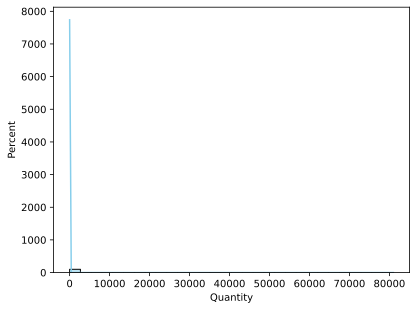

In [56]:
sns.histplot(data['Quantity'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Percent'>

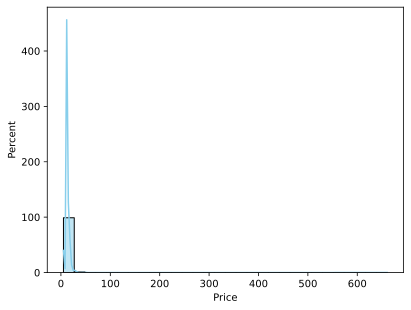

In [57]:
sns.histplot(data['Price'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

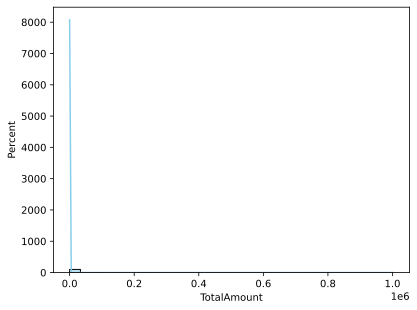

In [58]:
sns.histplot(data['TotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

In [59]:
# plt.subplot(1,2,2)
# sns.boxplot(data = data[['Quantity']])
# plt.title("Quantity distribution", fontsize = 18)
# plt.yticks(fontsize = 14)

In [60]:
# plt.subplot(1,2,2)
# sns.boxplot(data = data[['Price']])
# plt.title("Price distribution", fontsize = 18)
# plt.yticks(fontsize = 14)

In [61]:
# plt.subplot(1,2,2)
# sns.boxplot(data = data[['TotalAmount']])
# plt.title("TotalAmount distribution", fontsize = 18)
# plt.yticks(fontsize = 14)

In [62]:
data.head(5)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalAmount,Year,Month,Day
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,2019,12,9
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,2019,12,9
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,2019,12,9
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,2019,12,9
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,2019,12,9


In [63]:
print(data['Quantity'].describe())

count    527764.000000
mean         10.594679
std         156.786795
min           1.000000
25%           1.000000
50%           3.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64


In [64]:
print(data['Price'].describe())

count    527764.000000
mean         12.629640
std           7.933224
min           5.130000
25%          10.990000
50%          11.940000
75%          14.090000
max         660.620000
Name: Price, dtype: float64


In [65]:
print(data['TotalAmount'].describe())

count    5.277640e+05
mean     1.193069e+02
std      1.851192e+03
min      5.130000e+00
25%      1.717000e+01
50%      4.383000e+01
75%      1.194000e+02
max      1.002718e+06
Name: TotalAmount, dtype: float64


# Dropping the columns that wont be used

In [66]:
data.drop(labels=['ProductName', 'Country'], inplace=True, axis=1)

In [67]:
data.head(5)

,TransactionNo,Date,ProductNo,Price,Quantity,CustomerNo,TotalAmount,Year,Month,Day
0,581482,2019-12-09,22485,21.47,12,17490.0,257.64,2019,12,9
1,581475,2019-12-09,22596,10.65,36,13069.0,383.40,2019,12,9
2,581475,2019-12-09,23235,11.53,12,13069.0,138.36,2019,12,9
3,581475,2019-12-09,23272,10.65,12,13069.0,127.80,2019,12,9
4,581475,2019-12-09,23239,11.94,6,13069.0,71.64,2019,12,9


In [68]:
# Calculate the "present day" for metrics like Recency
presentDay = data['Date'].max()

# Calculate date metrics
firstPurchase = data.groupby('CustomerNo')['Date'].min()
lastPurchase = data.groupby('CustomerNo')['Date'].max()

# Calculate customer lifespan metrics
# We don't want 0 in active days, as it's false. First day counts as 1.
activeDays = (lastPurchase - firstPurchase).dt.days + 1
recency = (presentDay - lastPurchase).dt.days
activeYears = activeDays / 365.25
activeMonths = activeDays / 30.44

customerData = data.groupby('CustomerNo').agg(
    # CLV
    Monetary = ('TotalAmount', 'sum'),
    
    # Average item Price
    AvgPrice = ('Price', 'mean'), 

    # Average Total Amount per transaction
    AvgTotalAmount = ('TotalAmount', 'mean'), 

    # Average Quantity purchased per item
    AvgQuantity = ('Quantity', 'mean'), 
    
    # How many unique products bought
    ProductDiversity = ('ProductNo', 'nunique')
)

# Number of *invoices* per customer (true purchase frequency)
purchaseFrequency = data.groupby('CustomerNo')['TransactionNo'].nunique()

monetary = data.groupby('CustomerNo')['TotalAmount'].sum()

# Calculate averages for more metrics
AvgYearlyPurchase = monetary / activeYears
AvgMonthlyPurchase = monetary / activeMonths

# Frequency
customerData['Frequency'] = purchaseFrequency

# Recency (Days since last purchase) merge
customerData['Recency'] = recency

# Active days
customerData['ActiveDays'] = activeDays

customerData.head(10)

,Monetary,AvgPrice,AvgTotalAmount,AvgQuantity,ProductDiversity,Frequency,Recency,ActiveDays
CustomerNo,,,,,,,,
12004.0,1509.60,15.042679,26.957143,1.857143,56,1,227,1
12006.0,24.76,12.380000,24.760000,2.000000,1,1,218,1
12008.0,5689.57,14.022660,28.027438,2.073892,203,1,276,1
12013.0,69.96,23.320000,69.960000,3.000000,1,1,359,1
12024.0,149.52,10.680000,29.904000,2.800000,5,1,176,1
12025.0,1021.59,14.754348,22.208478,1.695652,46,1,287,1
12026.0,20486.32,13.416406,50.088802,4.105134,406,1,339,1
12031.0,136.18,7.074286,19.454286,2.857143,7,1,70,1
12042.0,6296.77,14.990404,28.236637,2.062780,223,1,264,1


In [69]:
print(customerData['Monetary'].describe())

count    4.718000e+03
mean     1.334589e+04
std      5.439743e+04
min      5.970000e+00
25%      1.838447e+03
50%      4.828470e+03
75%      1.190628e+04
max      2.112282e+06
Name: Monetary, dtype: float64


In [70]:
print(customerData['Frequency'].describe())

count    4718.000000
mean        4.194362
std         7.396101
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       207.000000
Name: Frequency, dtype: float64


In [71]:
print(customerData['Recency'].describe())

count    4718.000000
mean       95.992794
std       101.758271
min         0.000000
25%        18.000000
50%        53.000000
75%       155.750000
max       373.000000
Name: Recency, dtype: float64


In [72]:
print(customerData['AvgTotalAmount'].describe())

count      4718.000000
mean        471.716875
std       13246.086964
min           5.970000
25%          49.536951
50%         101.248289
75%         150.808220
max      840113.800000
Name: AvgTotalAmount, dtype: float64


In [73]:
dataOutliersMonetary = customerData[customerData['Monetary'] > customerData['Monetary'].quantile(0.98)]
dataOutliersMonetary = customerData[customerData['Frequency'] > customerData['Frequency'].quantile(0.98)]
dataOutliersMonetary = customerData[customerData['Recency'] > customerData['Recency'].quantile(0.98)]
dataOutliersMonetary = customerData[customerData['AvgTotalAmount'] > customerData['AvgTotalAmount'].quantile(0.98)]
dataOutliersMonetary = customerData[customerData['AvgPrice'] > customerData['AvgPrice'].quantile(0.98)]

customerData = customerData[customerData['Monetary'] < customerData['Monetary'].quantile(0.98)]
customerData = customerData[customerData['Frequency'] < customerData['Frequency'].quantile(0.98)]
customerData = customerData[customerData['Recency'] < customerData['Recency'].quantile(0.98)]
customerData = customerData[customerData['AvgTotalAmount'] < customerData['AvgTotalAmount'].quantile(0.98)]
customerData = customerData[customerData['AvgPrice'] < customerData['AvgPrice'].quantile(0.98)]

In [82]:
print(customerData['Monetary'].describe())

count     4247.000000
mean      8085.097648
std       9571.205075
min          5.970000
25%       1874.890000
50%       4638.900000
75%      10679.820000
max      70145.450000
Name: Monetary, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Monetary', ylabel='Percent'>

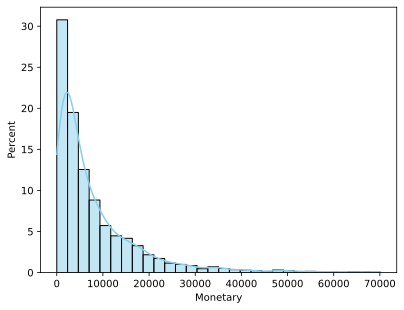

In [74]:
sns.histplot(customerData['Monetary'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Frequency', ylabel='Percent'>

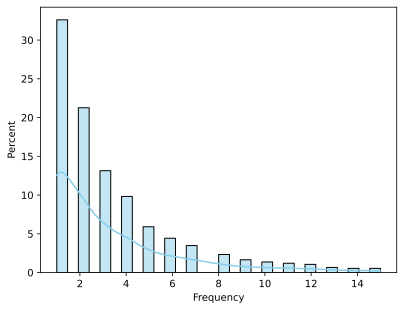

In [75]:
sns.histplot(customerData['Frequency'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Recency', ylabel='Percent'>

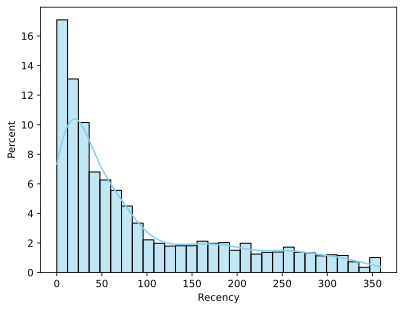

In [76]:
sns.histplot(customerData['Recency'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgTotalAmount', ylabel='Percent'>

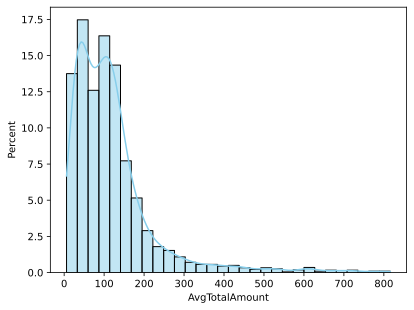

In [77]:
sns.histplot(customerData['AvgTotalAmount'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ActiveDays', ylabel='Percent'>

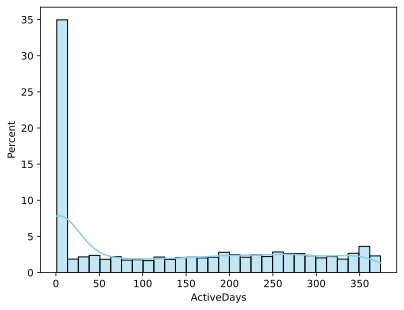

In [78]:
sns.histplot(customerData['ActiveDays'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgQuantity', ylabel='Percent'>

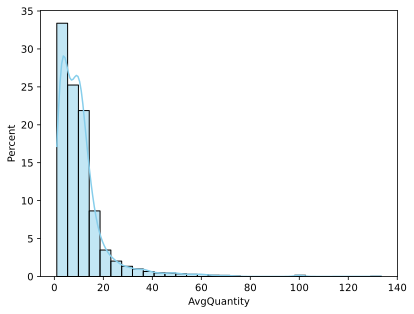

In [79]:
sns.histplot(customerData['AvgQuantity'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='AvgPrice', ylabel='Percent'>

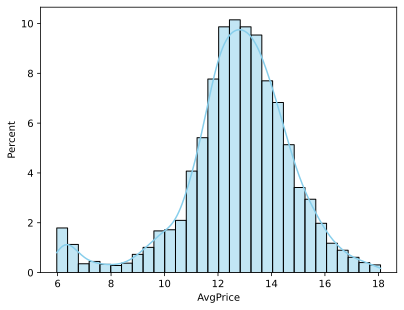

In [80]:
sns.histplot(customerData['AvgPrice'],bins=30, kde=True, color="skyblue", stat="percent")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ProductDiversity', ylabel='Percent'>

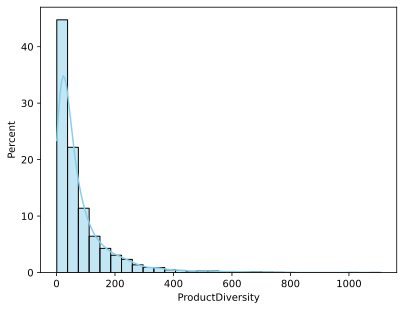

In [81]:
sns.histplot(customerData['ProductDiversity'],bins=30, kde=True, color="skyblue", stat="percent")